# Teste A/B Bayesiano

Para artigo original [clique aqui](http://www.marcosantoni.com/2016/05/15/bayesian-ab-testing-in-python.html)

Imagine você reprojetando seu site de comércio eletrônico. Você tem que decidir se o botão "Comprar Item" deve ser azul ou verde. Você decide configurar um teste A / B para criar duas versões da página do item:

- Página A que tem um botão azul;
- Página B que tem um botão verde.

As páginas A e B são idênticas, exceto pela cor do botão. Você deseja quantificar a probabilidade de um usuário clicar no botão "Comprar Item" quando ela estiver na página A ou na página B. Assim, a experiência iniciará enviando cada usuário para a página A ou para a página B. Cada vez, você irá monitorar se ela clicou em "Comprar Item" ou não.

### Frequentista vs Bayesiano

Pode-se simplesmente aproximar a eficácia de cada página, calculando a taxa de sucesso nas duas páginas. Por exemplo. se N = 1000 usuários visitaram a página A e 50 deles clicaram no botão, pode-se dizer que a probabilidade de clicar no botão na página A é 50/1000 = 5%. Esta é a chamada abordagem freqüentista, que prevê a probabilidade em termos de freqüência de eventos. No entanto, os seguintes problemas podem surgir diariamente:

- E se N for pequeno (por exemplo, N = 50)? Podemos ainda estar confiantes apenas calculando a taxa de sucesso?
- E se N for diferente entre a página A e a página B? Digamos que 500 usuários visitaram a página A e 2000 usuários visitaram a página B. Como podemos combinar esses experimentos desequilibrados?
- Quão grande deve ser para atingir 90% de confiança em minhas estimativas?

Vamos agora introduzir uma solução Bayesiana simples que permite executar o teste A / B e lidar com os problemas listados acima. O código faz uso do pacote PyMC e foi inspirado pela leitura de "Métodos bayesianos para hackers", de Cameron Davidson-Pilon.

### Avaliar a página A

Primeiramente mostraremos como avaliar a taxa de sucesso na página A com uma abordagem bayesiana. O objetivo é inferir a probabilidade de clicar no botão "Comprar Item" na página A. Modelamos essa probabilidade como uma distribuição de Bernoulli com o parâmetro pA:

$$ P (clique em | página = A) = p_A (click = 1) $$
$$ P (clique em | página = A) =  1-p_A (clique = 0) $$

Então, pA
é o parâmetro que indica a probabilidade de clicar no botão na página A. Esse parâmetro é desconhecido e o objetivo do experimento é inferi-lo.

In [9]:
from pymc import Uniform, rbernoulli, Bernoulli, MCMC
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# true value of p_A (unknown)
p_A_true = 0.05
# number of users visiting page A
N = 1500
occurrences = rbernoulli(p_A_true, N)

print ('Click-BUY:')
print (occurrences.sum())
print ('Observed frequency:')
print (occurrences.sum() / float(N))

Click-BUY:
69
Observed frequency:
0.046


Neste código, estamos simulando uma realização do experimento em que 1.500 usuários visitaram a página A. Aqui, as ocorrências indicam quantos visitantes realmente clicaram no botão nessa realização.

O próximo passo consiste em definir o nosso *prior* no parâmetro $p_A$. A definição prévia é o primeiro passo da inferência bayesiana e é uma maneira de indicar nossa crença anterior na variável.

In [10]:
p_A = Uniform('p_A', lower=0, upper=1)
obs = Bernoulli('obs', p_A, value=occurrences, observed=True)

Nesta seção, definimos o prior de $p_A$ como uma distribuição uniforme. A variável obs indica a distribuição de Bernoulli representando as observações dos eventos de clique (na verdade, regidos pelo parâmetro $p_A$). As duas variáveis são atribuídas a *Uniform* e *Bernoulli*, que são objetos de variáveis estocásticas, parte do PyMC. Cada variável é associada a um nome de string ($p_A$ e *obs* neste caso). A variável *obs* tem o valor e o conjunto de parâmetros observados porque observamos as realizações dos experimentos. Vamso utilizar o MCMD (Monte Carlo Markov Chain Model).

Na estatística, os métodos de Monte Carlo da cadeia de Markov (MCMC) compreendem uma classe de algoritmos para amostragem a partir de uma distribuição de probabilidade. Construindo uma cadeia de Markov que tem a distribuição desejada como sua distribuição de equilíbrio, pode-se obter uma amostra da distribuição desejada observando a cadeia após um certo número de etapas. Quanto mais etapas houver, mais de perto a distribuição da amostra corresponderá à distribuição real desejada.

Uma cadeia de Markov é um modelo estocástico que descreve uma sequência de possíveis eventos nos quais a probabilidade de cada evento depende apenas do estado alcançado no evento anterior.

Os métodos de Monte Carlo (ou experimentos de Monte Carlo) são uma ampla classe de algoritmos computacionais que se baseiam em amostragens aleatórias repetidas para obter resultados numéricos. Sua ideia essencial é usar aleatoriedade para resolver problemas que podem ser determinísticos em princípio. Eles são freqüentemente usados em problemas físicos e matemáticos e são mais úteis quando é difícil ou impossível usar outras abordagens. Os métodos de Monte Carlo são usados principalmente em três classes de problemas: otimização, integração numérica e geração de gráficos a partir de uma distribuição de probabilidade.

In [11]:
# defining a Monte Carlo Markov Chain model
mcmc = MCMC([p_A, obs])
# setting the size of the simulations to 20k 
mcmc.sample(20000, 1000)
# the resulting posterior distribution is stored in the trace variable
print (mcmc.trace('p_A')[:])

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec[ 0.0413853   0.0413853   0.0413853  ...,  0.04513473  0.04513473
  0.04513473]


O modelo **MCMC** é inicializado e as variáveis $p_A$ e obs são dadas a ele como entrada. O modelo de amostra executará as simulações de Monte Carlo e ajustará os dados observados à crença anterior. A distribuição posterior é acessível através do atributo .trace como uma matriz de realizações. Podemos agora visualizar o resultado da inferência.

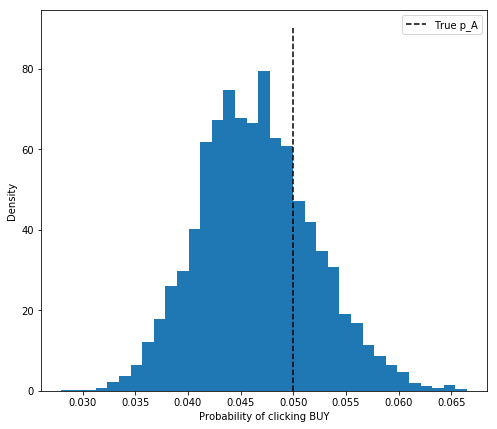

In [12]:
plt.figure(figsize=(8, 7))
plt.hist(mcmc.trace('p_A')[:], bins=35, histtype='stepfilled',
normed=True)
plt.xlabel('Probability of clicking BUY')
plt.ylabel('Density')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A')
plt.legend()
plt.show()

Então, poderíamos querer responder à pergunta: onde tenho 90% de certeza de que o verdadeiro $p_A$ está? Isso é fácil de responder.

In [13]:
p_A_samples = mcmc.trace('p_A')[:]
lower_bound = np.percentile(p_A_samples, 0.5)
upper_bound = np.percentile(p_A_samples, 0.95)
print ('There is 90%% probability that p_A is between %s and %s' % (lower_bound, upper_bound))

There is 90% probability that p_A is between 0.033650815465 and 0.0348373954394


### Comparando a página A e a página B

Vamos agora repetir o que fizemos para a página A, e adicionamos uma nova variável delta indicando a diferença entre $p_A$ e $p_B$.

Observed frequency:
A
0.0453333333333
B
0.0386666666667
 [-----------------100%-----------------] 25000 of 25000 complete in 3.2 sec

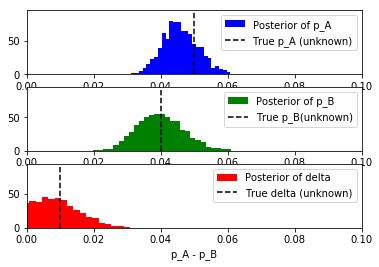

In [14]:
from pymc import Uniform, rbernoulli, Bernoulli, MCMC, deterministic
from matplotlib import pyplot as plt

p_A_true = 0.05
p_B_true = 0.04
N_A = 1500
N_B = 750

occurrences_A = rbernoulli(p_A_true, N_A)
occurrences_B = rbernoulli(p_B_true, N_B)

print ('Observed frequency:')
print ('A')
print (occurrences_A.sum() / float(N_A))
print ('B')
print (occurrences_B.sum() / float(N_B))

p_A = Uniform('p_A', lower=0, upper=1)
p_B = Uniform('p_B', lower=0, upper=1)

@deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = Bernoulli('obs_A', p_A, value=occurrences_A, observed=True)
obs_B = Bernoulli('obs_B', p_B, value=occurrences_B, observed=True)

mcmc = MCMC([p_A, p_B, obs_A, obs_B, delta])
mcmc.sample(25000, 5000)

p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

plt.subplot(3,1,1)
plt.xlim(0, 0.1)
plt.hist(p_A_samples, bins=35, histtype='stepfilled', normed=True,
color='blue', label='Posterior of p_A')
plt.vlines(p_A_true, 0, 90, linestyle='--', label='True p_A (unknown)')
plt.xlabel('Probability of clicking BUY via A')
plt.legend()
plt.subplot(3,1,2)
plt.xlim(0, 0.1)
plt.hist(p_B_samples, bins=35, histtype='stepfilled', normed=True,color='green', label='Posterior of p_B')
plt.vlines(p_B_true, 0, 90, linestyle='--', label='True p_B(unknown)')
plt.xlabel('Probability of clicking BUY via B')
plt.legend()
plt.subplot(3,1,3)
plt.xlim(0, 0.1)
plt.hist(delta_samples, bins=35, histtype='stepfilled', normed=True,color='red', label='Posterior of delta')
plt.vlines(p_A_true - p_B_true, 0, 90, linestyle='--', label='True delta (unknown)')
plt.xlabel('p_A - p_B')
plt.legend()
plt.show()

Então, podemos responder a uma pergunta como: qual é a probabilidade de que $p_A$ > $p_B$?

In [15]:
print ('Probability that p_A > p_B:')
print ((delta_samples > 0).mean())

Probability that p_A > p_B:
0.7485
